In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.signal import argrelextrema
import scipy.constants as const
from arc import *

# Polarizability

The ARC package returns the atom polarizability in SI units $$\alpha_0 = \left[Hz m^2/V^2 \right] \ .$$ To convert from electric field to intesity we use the Poyinting vector assuming plane waves (also valid for the peak intensity of gaussian beams): $$ I= \frac{1}{2} c \epsilon_0 E^2 \ .$$ With this we can express the polarizability in terms of Hz m^2/W as $$\alpha^\prime= \frac{2\alpha_0}{c\epsilon_0}$$ or in terms of Hz cm^2/mW as $$\alpha^\prime= 10\frac{2\alpha_0}{c\epsilon_0}$$
Note that we used peak electric field while in ARC they used rms electric field. So in the calculation of trap depth remeber to divide by 4 (for a focused gaussian beam)

In [20]:
atom = Rubidium87()
laser_L= 767e-9 # wavelenght in m
P= 400e-3 # W. Power of a single beam. In total we have 6 for 3D confinement.
phi = np.deg2rad(14.7/2) # half the angle between the two crossing beams
phi = np.deg2rad(40/2) # half the angle between the two crossing beams
phi = np.deg2rad(14.7/2) # half the angle between the two crossing beams


laser_L_red= 1064e-9 # wavelenght in m
P_red= 5000e-3 # W. Power of a single beam. In total we have 6 for 3D confinement.
phi_red = np.deg2rad(20.4/2) # angle between the optical axis and one of the two beams

P_795= 60e-3 # W. Power of a single beam. In total we have 6 for 3D confinement.
phi_795 = np.deg2rad(14.7/2) # half the angle between the two crossing beams
phi_795 = np.deg2rad(40/2) # half the angle between the two crossing beams




In [3]:
def trap_depth_gaussian(pol, P, wx, wy):
    """ trap depth for a focused gaussian beam
        pol: polarizability in units of Hz m^2/W
        P: power of the beam (W)
        wx: waist along x direction in m
        wy: waist along y direction in m
        return trap depth in Hz
    """
    I0_elliptical_xy= 2*P/ (np.pi* wx * wy) #multiply waists from um to cm such 
    U0_xy = - pol * I0_elliptical_xy/4 #in Hz. Divide by 4 because we used peak electric field in the calculation
                                    #of polarizability instead of rms.
    return U0_xy

## Ground state

In [4]:
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)
alpha0, alpha1, alpha2, core, dynamic, closestState = calc.getPolarizability(laser_L, units="SI", accountForStateLifetime=True)

# print("alpha0 = %.3e Hz m^2/V^2." % (alpha0))
# print("alpha1 = %.3e Hz m^2/V^2." % (alpha1))
# print("alpha2 = %.3e Hz m^2/V^2." % (alpha2))
polB_GS=2*alpha0*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarizability of GS with 767 light = %.3e Hz m^2/W." % (polB_GS))
alpha0_R, alpha1_R, alpha2_R, core_R, dynamic_R, closestStateR = calc.getPolarizability(laser_L_red, units="SI", accountForStateLifetime=True)

# print("alpha0_R = %.3e Hz m^2/V^2." % (alpha0_R))
# print("alpha1_R = %.3e Hz m^2/V^2." % (alpha1_R))
# print("alpha2_R = %.3e Hz m^2/V^2." % (alpha2_R))
polR_GS=2*alpha0_R*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarizability of GS with 1064 light = %.3e Hz m^2/W." % (polR_GS))

Polarizability of GS with 767 light = -1.361e-01 Hz m^2/W.
Polarizability of GS with 1064 light = 1.273e-02 Hz m^2/W.


In [5]:
laser_795_f= atom.getTransitionFrequency(atom.groundStateN, 0, 0.5, atom.groundStateN, 1, 0.5)+ 30e9
laser_795_L= const.c/laser_795_f

alpha0, alpha1, alpha2, core, dynamic, closestState = calc.getPolarizability(laser_795_L, units="SI", accountForStateLifetime=True)
pol795_GS=2*alpha0*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarizability of GS with 795 light = %.3e Hz m^2/W." % (pol795_GS))
alpha0_R, alpha1_R, alpha2_R, core_R, dynamic_R, closestStateR = calc.getPolarizability(laser_795_L, units="SI", accountForStateLifetime=True)


Polarizability of GS with 795 light = -1.217e+01 Hz m^2/W.


# Crossed 3D lattice simulation

The aim of this simulation is the calculation of a 3D lattice potential generated by 3 pair of crossed beams. The aim is to calculate the number of trapping sites for given beam waists (assuming elliptical beams) that have a trapping depth at least 90% of the deepest central trap.


In [6]:
def rayleigh(w,L): #returns rayleigh range 
    return np.pi*(w**2)/L

## Potential funtion:


<div>
<img src="attachment:image.png" width="500">
</div>
This function assumes two beams with wavelenght L, with a given waist (w_x and w_y) propagating in the x-z plane crossing at an agle 2*phi from each other. They will form a 1D lattice along the x direction.
In the x-z plane each beam will "create" a trap at the focus that can be described by an ellipse rotated by an angle phi. w0x^~ and w0z^~ delimit the intersection region fo the two ellipses

In [7]:
def potential(x,y,z,phi,w_x,w_y,L,U0,axis):
    """
    U0: is potential in the deepest trap generated by a single focused beam
    axis: by default axis is 'x', meaning that the lattice is formed along the x direction. 
    """
#     # helper funtion that permutes x,y,z variables in order to generate lattices in other dimensions other than 'x'
#     # such that we can recycle this function for a 2D and 3D lattice potential.
#     if axis == 'y':
#         x,y,z = -y, z,-x
#     elif axis == 'x':
#         x,y,z = x, z,-y 
#     elif axis == 'z':
#         x,y,z = -z, x, -y
    
    k = 2*np.pi*np.sin(phi)/L

    w_0x = np.sqrt(1/((np.cos(phi)/w_x)**2 + 0.5*((np.sin(phi)/rayleigh(w_x,L))**2)))
    w_0z = np.sqrt(1/((np.sin(phi)/w_x)**2 + 0.5*((np.cos(phi)/rayleigh(w_x,L))**2)))
    
    #notice that in this case the y waist remains the same as expected.

    return 4*U0*(np.cos(k*x)**2)*(1 - 2*(x/w_0x)**2 - 2*(y/w_y)**2 - (z/w_0z)**2 ) # 4 becasue of the constructive intereference

### Sanity check: Tweezer
1.7 mW of 852nm focused on a round waist of 0.75 um, should yieald 1 mK trap depth

In [8]:
alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(852e-9, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/mW. We consider only the scalar polarizability
print("Polarization of GS with 852nm = %.3e Hz cm^2/mW." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, 1.7e-3, 0.75e-6, 0.75e-6) #in Hz
print("Trap depth in uK: ", U0_tweezer*const.h/const.k*1e6)

Polarization of GS with 852nm = 3.884e-02 Hz cm^2/mW.
Trap depth in uK:  -896.5382499349503


In [9]:
calc2 = DynamicPolarizability(atom, 5,1,3/2)
calc2.defineBasis(atom.groundStateN, atom.groundStateN+15)
alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc2.getPolarizability(826e-9, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/mW. We consider only the scalar polarizability
print("Polarizability of GS with 826nm = %.3e Hz cm^2/mW." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, 1.7e-3, 0.75e-6, 0.75e-6) #in Hz
print("Trap depth in uK: ", U0_tweezer*const.h/const.k*1e6)
print("Scalar polarizability: %.3e, vector polarizability:%.3e and tensor:%.3e"% (alpha0_twz, alpha1_twz, alpha2_twz))

Polarizability of GS with 826nm = -2.126e-02 Hz cm^2/mW.
Trap depth in uK:  490.6617411937962
Scalar polarizability: -2.821e-05, vector polarizability:-6.996e-05 and tensor:2.815e-05


## One wavelength crossed 795 3D lattice
Here we assume one wavelength only (767 nm), and elliptical beams. Using elliptical beams makes the interference region more cicular (more power efficient).

4 beams are incident on the same lens (on the side of the vacuum can). Two are parallel to the optical table, and the other two are perpendicular. These 4 beams generate a 2-D lattice in the x-y plane (plane parallel to the optical table) that is loosely confined along the horizontal direction (sigar shape lattice). 
For a stronger confinement along the weak axis (Z) we add an extra pair of beams coming from the top viewport. Since we are interested in a 2D lattice we want the these beams to be as tight as possible along one axis since we are interested in one central pancake. 

The relative angle between the two beams is 14.7 deg

In [10]:
large_waist_x =2*130e-6 # m
# beams creating a lattice along x. They come along the side of the chamber. Propagating on the plane perpendicular to the optical table
wx_z = large_waist_x#/2
wx_x = large_waist_x

# beams creating a lattice along y. They come from top of the chamber and parallel to the 2D-lattice (tweezer focal plane)
large_waist_y =2*100e-6 # m
wy_z = large_waist_y#/2
wy_y = large_waist_y 

# beams creating a lattice along z. they come along the side of the chamber and are parallel to the optical table
large_waist_z =2*130e-6 # unit is m 
wz_z = large_waist_z#/2
wz_x = large_waist_z 


## Trap depth
U0_x = 4*trap_depth_gaussian(pol795_GS, P_795, wx_x, wx_z) # Hz. There is a factor of 4 because we have the intereference of a crossed beam
U0x_inJ= U0_x *const.h
U0_y = 4*trap_depth_gaussian(pol795_GS, P_795, wy_y, wy_z) # Hz. There is a factor of 4 because we have the intereference of a crossed beam
U0y_inJ= U0_y *const.h
U0_z = 4*trap_depth_gaussian(pol795_GS, P_795, wz_x, wz_z) # Hz
U0z_inJ= U0_z*const.h

depth = round(U0_x + U0_y) # total trap depth
depth_uK = round(depth * const.h/const.k *1e6)
print("Maximum trap depth in 3D:",depth_uK," uK")

#Lattice spacing
d= laser_L/(2*np.sin(phi)) #lattice spacing in m
print("Lattice spacing", round(d*1e6,2), "um")

## Trap frequencies
k_L= np.pi* np.sin(phi)/laser_795_L 
mass_Rb = 87*const.u
omega_x = (np.sqrt(8 * np.pi**2* (U0x_inJ/4)/(mass_Rb*d**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
omega_y = (np.sqrt(8 * np.pi**2* (U0y_inJ/4)/(mass_Rb*d**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
omega_z=  (np.sqrt(8 * np.pi**2* (U0z_inJ/4)/(mass_Rb*d**2))) / (2*np.pi)
print("Trap frequency x: 2pi x",round(omega_x*1e-3), "kHz")
print("Trap frequency y: 2pi x",round(omega_y*1e-3), "kHz")
print("Trap frequency z: 2pi x",round(omega_z*1e-3), "kHz")


Maximum trap depth in 3D: 888  uK
Lattice spacing 0.77 um
Trap frequency x: 2pi x 164 kHz
Trap frequency y: 2pi x 213 kHz
Trap frequency z: 2pi x 164 kHz


In [11]:
# Potential in space

grid= 70e-6
points_in_grid= 5001
x = np.linspace(-grid,grid,points_in_grid)
y = np.linspace(-grid,grid,points_in_grid)
X,Y = np.meshgrid(x,y)

# Z = (potential(X,Y,0,phi, wx_x, wx_z,laser_L, U0_x/4,'x') + 
#      potential(X,Y,0,phi, wy_y, wy_z,laser_L, U0_y/4,'y') + 
#      potential(X,Y,0,phi, wz_z, wz_x,laser_L, U0_z/4,'z'))/depth
Z = (potential(X,0,-Y, phi, wx_x, wx_z,laser_L, U0_x/4,'x') + 
     potential(-Y,0,-X,phi, wy_y, wy_z,laser_L, U0_y/4,'y') + 
     potential(0,X,-Y, phi, wz_z, wz_x,laser_L, U0_z/4,'z'))/depth

# extract only the points where the trap depth is within 80% of the maxima
Zcut = Z.copy()
Zcut[(Z-0.8)<0] = 0

###  Number of traps in the two directions within 80% of the max trap depth
This means approximately that the difference in trap frequency is 10%.

In [12]:
n_xaxis = len(argrelextrema(Zcut[round(points_in_grid/2)], np.greater)[0])
n_yaxis = len(argrelextrema(Zcut[:, round(points_in_grid/2)], np.greater)[0])
print("Traps along x axis: ", n_xaxis )
print("Traps along y axis: ", n_yaxis )

# assuming that is it roughly circular, calculate the lenght of the square inscribed the circle
# square_lenght= round(min(n_xaxis, n_yaxis)/np.sqrt(2))
rect_x = round(n_xaxis/np.sqrt(2))
rect_y = round(n_yaxis/np.sqrt(2))
print("rectangular array size ",rect_x, " by",rect_y )

Traps along x axis:  183
Traps along y axis:  183
rectangular array size  129  by 129


## One wavelength crossed blue 3D lattice
Here we assume one wavelength only (767 nm), and elliptical beams. Using elliptical beams makes the interference region more cicular (more power efficient).

4 beams are incident on the same lens (on the side of the vacuum can). Two are parallel to the optical table, and the other two are perpendicular. These 4 beams generate a 2-D lattice in the x-y plane (plane parallel to the optical table) that is loosely confined along the horizontal direction (sigar shape lattice). 
For a stronger confinement along the weak axis (Z) we add an extra pair of beams coming from the top viewport. Since we are interested in a 2D lattice we want the these beams to be as tight as possible along one axis since we are interested in one central pancake. 

The relative angle between the two beams is 14.7 deg

In [21]:
large_waist_x =2*130e-6 # m
# beams creating a lattice along x. They come along the side of the chamber. Propagating on the plane perpendicular to the optical table
wx_z = large_waist_x#/2
wx_x = large_waist_x

# beams creating a lattice along y. They come from top of the chamber and parallel to the 2D-lattice (tweezer focal plane)
large_waist_y =2*100e-6 # m
wy_z = large_waist_y#/2
wy_y = large_waist_y 

# beams creating a lattice along z. they come along the side of the chamber and are parallel to the optical table
large_waist_z =2*130e-6 # unit is m 
wz_z = large_waist_z#/2
wz_x = large_waist_z 


## Trap depth
U0_x = 4*trap_depth_gaussian(polB_GS, P, wx_x, wx_z) # Hz. There is a factor of 4 because we have the intereference of a crossed beam
U0x_inJ= U0_x *const.h
U0_y = 4*trap_depth_gaussian(polB_GS, P, wy_y, wy_z) # Hz. There is a factor of 4 because we have the intereference of a crossed beam
U0y_inJ= U0_y *const.h
U0_z = 4*trap_depth_gaussian(polB_GS, P, wz_x, wz_z) # Hz
U0z_inJ= U0_z*const.h

depth = round(U0_x + U0_y) # total trap depth
depth_uK = round(depth * const.h/const.k *1e6)
print("Maximum trap depth in 3D:",depth_uK," uK")

#Lattice spacing
d= laser_L/(2*np.sin(phi)) #lattice spacing in m
print("Lattice spacing", round(d*1e6,2), "um")

## Trap frequencies
k_L= np.pi* np.sin(phi)/laser_L 
mass_Rb = 87*const.u
omega_x = (np.sqrt(8 * np.pi**2* (U0x_inJ/4)/(mass_Rb*d**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
omega_y = (np.sqrt(8 * np.pi**2* (U0y_inJ/4)/(mass_Rb*d**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
omega_z=  (np.sqrt(8 * np.pi**2* (U0z_inJ/4)/(mass_Rb*d**2))) / (2*np.pi)
print("Trap frequency x: 2pi x",round(omega_x*1e-3), "kHz")
print("Trap frequency y: 2pi x",round(omega_y*1e-3), "kHz")
print("Trap frequency z: 2pi x",round(omega_z*1e-3), "kHz")


Maximum trap depth in 3D: 66  uK
Lattice spacing 3.0 um
Trap frequency x: 2pi x 11 kHz
Trap frequency y: 2pi x 15 kHz
Trap frequency z: 2pi x 11 kHz


In [22]:
# Potential in space

grid= 70e-6
points_in_grid= 1001
x = np.linspace(-grid,grid,points_in_grid)
y = np.linspace(-grid,grid,points_in_grid)
X,Y = np.meshgrid(x,y)

# Z = (potential(X,Y,0,phi, wx_x, wx_z,laser_L, U0_x/4,'x') + 
#      potential(X,Y,0,phi, wy_y, wy_z,laser_L, U0_y/4,'y') + 
#      potential(X,Y,0,phi, wz_z, wz_x,laser_L, U0_z/4,'z'))/depth
Z = (potential(X,0,-Y, phi, wx_x, wx_z,laser_L, U0_x/4,'x') + 
     potential(-Y,0,-X,phi, wy_y, wy_z,laser_L, U0_y/4,'y') + 
     potential(0,X,-Y, phi, wz_z, wz_x,laser_L, U0_z/4,'z'))/depth

# extract only the points where the trap depth is within 80% of the maxima
Zcut = Z.copy()
Zcut[(Z-0.8)<0] = 0

###  Number of traps in the two directions within 80% of the max trap depth
This means approximately that the difference in trap frequency is 10%.

In [23]:
n_xaxis = len(argrelextrema(Zcut[round(points_in_grid/2)], np.greater)[0])
n_yaxis = len(argrelextrema(Zcut[:, round(points_in_grid/2)], np.greater)[0])
print("Traps along x axis: ", n_xaxis )
print("Traps along y axis: ", n_yaxis )

# assuming that is it roughly circular, calculate the lenght of the square inscribed the circle
# square_lenght= round(min(n_xaxis, n_yaxis)/np.sqrt(2))
rect_x = round(n_xaxis/np.sqrt(2))
rect_y = round(n_yaxis/np.sqrt(2))
print("rectangular array size ",rect_x, " by",rect_y )

Traps along x axis:  47
Traps along y axis:  47
rectangular array size  33  by 33


### Plot the 2D array

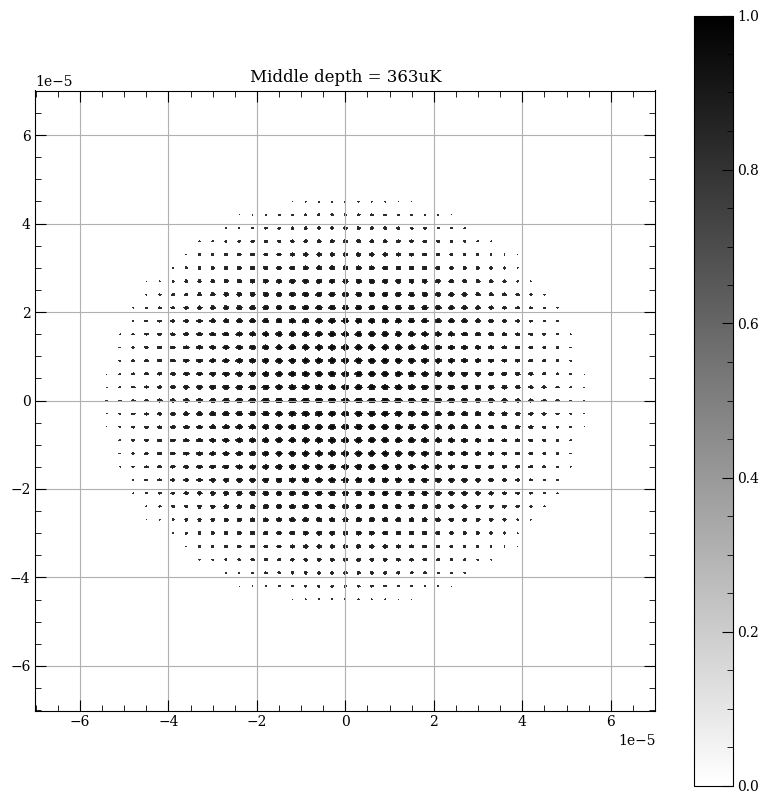

In [12]:
fig,ax = plt.subplots(figsize=[10,10])
p = ax.pcolormesh(X,Y,Zcut,vmin = 0, vmax = 1,cmap='gray_r')
title = "Middle depth = " + str(depth_uK) + str("uK")
ax.set_aspect('equal')
ax.set_title(title)
plt.grid()
fig.colorbar(p,ax=ax)

## One wavelength red 3D lattice
Here we assume one wavelength only (1064 nm), and elliptical beams. Using elliptical beams makes the interference region more cicular (more power efficient).

4 beams are incident on the same lens (on the side of the vacuum can). Two are parallel to the optical table, and the other two are perpendicular. These 4 beams generate a 2-D lattice in the x-y plane (plane parallel to the optical table) that is loosely confined along the horizontal direction (sigar shape lattice). 
For a stronger confinement along the weak axis (Z) we add an extra pair of beams coming from the top viewport. Since we are interested in a 2D lattice we want the these beams to be as tight as possible along one axis since we are interested in one central pancake. 

The relative angle between the two beams is 20.4 deg

In [76]:
large_waist_x =2*130e-6 # m
# beams creating a lattice along x. They come along the side of the chamber. Propagating on the plane perpendicular to the optical table
wx_z = large_waist_x#/2
wx_x = large_waist_x

# beams creating a lattice along y. They come from top of the chamber and parallel to the 2D-lattice (tweezer focal plane)
large_waist_y =2*100e-6 # m
wy_z = large_waist_y#/2
wy_y = large_waist_y 

# beams creating a lattice along z. they come along the side of the chamber and are parallel to the optical table
large_waist_z =2*130e-6 # unit is m 
wz_z = large_waist_z#/2
wz_x = large_waist_z 


## Trap depth
U0_x = 4*trap_depth_gaussian(polR_GS, P_red, wx_x, wx_z) # Hz. There is a factor of 4 because we have the intereference of a crossed beam
U0x_inJ= U0_x *const.h
U0_y = 4*trap_depth_gaussian(polR_GS, P_red, wy_y, wy_z) # Hz. There is a factor of 4 because we have the intereference of a crossed beam
U0y_inJ= U0_y *const.h
U0_z = 4*trap_depth_gaussian(polR_GS, P_red, wz_x, wz_z) # Hz
U0z_inJ= U0_z*const.h

depth = abs(round(U0_x + U0_y )) # total trap depth
depth_uK = round(depth * const.h/const.k *1e6)
print("Maximum trap depth in 3D:",depth_uK," uK")

#Lattice spacing
d= laser_L/(2*np.sin(phi_red)) #lattice spacing in m
print("Lattice spacing", round(d*1e6), "um")

## Trap frequencies
k_L= np.pi* np.sin(phi_red)/laser_L_red 
mass_Rb = 87*const.u
omega_x = (np.sqrt(8 * np.pi**2* (abs(U0x_inJ)/4)/(mass_Rb*d**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
omega_y = (np.sqrt(8 * np.pi**2* (abs(U0y_inJ)/4)/(mass_Rb*d**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
omega_z=  (np.sqrt(8 * np.pi**2* (abs(U0z_inJ)/4)/(mass_Rb*d**2))) / (2*np.pi)
print("Trap frequency x: 2pi x",round(omega_x*1e-3), "kHz")
print("Trap frequency y: 2pi x",round(omega_y*1e-3), "kHz")
print("Trap frequency z: 2pi x",round(omega_z*1e-3), "kHz")


Maximum trap depth in 3D: 77  uK
Lattice spacing 2 um
Trap frequency x: 2pi x 17 kHz
Trap frequency y: 2pi x 22 kHz
Trap frequency z: 2pi x 17 kHz


In [77]:
# Potential in space

grid= 70e-6
points_in_grid= 1001
x = np.linspace(-grid,grid,points_in_grid)
y = np.linspace(-grid,grid,points_in_grid)
X,Y = np.meshgrid(x,y)

# Z = (potential(X,Y,0,phi, wx_x, wx_z,laser_L, U0_x/4,'x') + 
#      potential(X,Y,0,phi, wy_y, wy_z,laser_L, U0_y/4,'y') + 
#      potential(X,Y,0,phi, wz_z, wz_x,laser_L, U0_z/4,'z'))/depth
Z = (potential(X,0,-Y, phi_red, wx_x, wx_z,laser_L_red, abs(U0_x)/4,'x') + 
     potential(-Y,0,-X,phi_red, wy_y, wy_z,laser_L_red, abs(U0_y)/4,'y') + 
     potential(0,X,-Y, phi_red, wz_z, wz_x,laser_L_red, abs(U0_z)/4,'z'))/depth

# extract only the points where the trap depth is within 80% of the maxima
Zcut = Z.copy()
Zcut[(Z-0.8)<0] = 0

###  Number of traps in the two directions within 80% of the max trap depth
This means approximately that the difference in trap frequency is 10%.

In [78]:
n_xaxis = len(argrelextrema(Zcut[round(points_in_grid/2)], np.greater)[0])
n_yaxis = len(argrelextrema(Zcut[:, round(points_in_grid/2)], np.greater)[0])
print("Traps along x axis: ", n_xaxis )
print("Traps along y axis: ", n_yaxis )

# assuming that is it roughly circular, calculate the lenght of the square inscribed the circle
# square_lenght= round(min(n_xaxis, n_yaxis)/np.sqrt(2))
rect_x = round(n_xaxis/np.sqrt(2))
rect_y = round(n_yaxis/np.sqrt(2))
print("rectangular array size ",rect_x, " by",rect_y )

Traps along x axis:  47
Traps along y axis:  47
rectangular array size  33  by 33


### Plot the 2D array

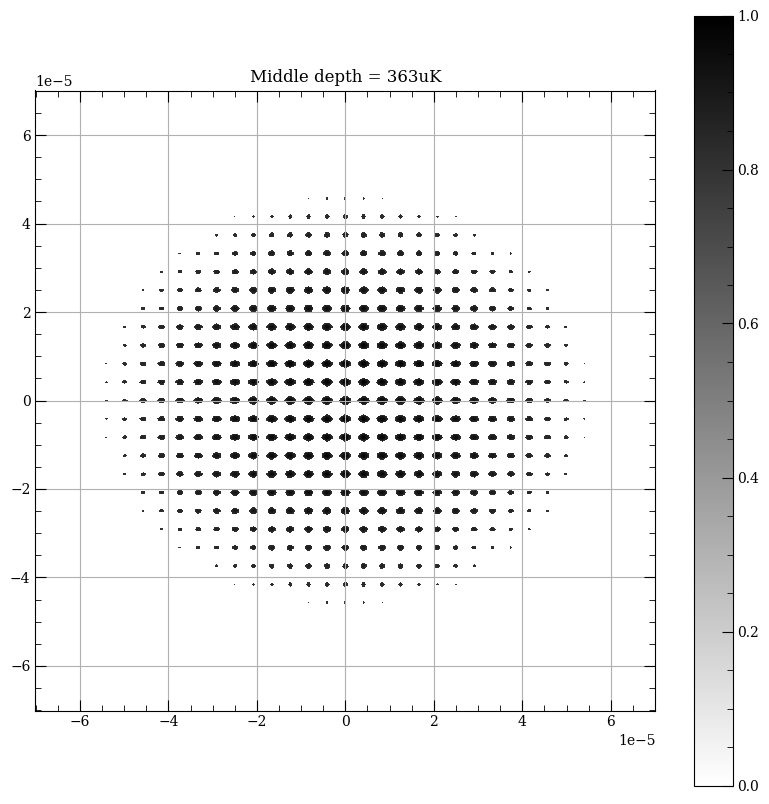

In [21]:
fig,ax = plt.subplots(figsize=[10,10])
p = ax.pcolormesh(X,Y,Zcut,vmin = 0, vmax = 1,cmap='gray_r')
title = "Middle depth = " + str(depth_uK) + str("uK")
ax.set_aspect('equal')
ax.set_title(title)
plt.grid()
fig.colorbar(p,ax=ax)

## Two wavelenght lattice

In [13]:
# P_1064= 3.6 # W

#beam parameters: XY
large_waist_red =250e-6 # m
wxy_red_x = large_waist_red/3 # is the small waist of the elliptical beams used for the x and y confinement beams (the ones incident on the same lens)
wxy_red_y = large_waist_red # same as above but the large waist of the elliptical beams
# Beams from above
large_waist_red_z =200e-6 # unit is m 
wz_red_x = large_waist_red_z/4 # beams coming from above short axis: as much squeezed as much as possible (chose 3 becuase that is the max from S+K optics)
wz_red_y = large_waist_red_z # beams from the bottom

U0_red = 230 # from ZZ simulations

U0_red_xy= (U0_red*100e-6*100e-6)/wxy_red_x/wxy_red_y
U0_red_z = (U0_red*100e-6*100e-6)/wz_red_x/wz_red_y
depth_red= round(2*U0_red_xy + U0_red_z)
print(depth_red)

# ## Trap depth
# U0_1064_z = 4*trap_depth_gaussian(polB_GS, P, wz_x, wz_y) # Hz
# U0_1064_z_inJ= U0_z*const.h
# U0_1064_xy = 4*trap_depth_gaussian(polB_GS, P, wxy_x, wxy_y) # Hz. There is a factor of 4 because we have the intereference of a crossed beam
# U0xy_1064_inJ= U0_xy *const.h

# depth1064_ = round(2*U0_xy + U0_z) # total trap depth
# depth_1064_uK = round(depth * const.h/const.k *1e6)
# print("Maximum trap depth in 3D:",depth_uK," uK")

#Lattice spacing
d_red= laser_L_red/(2*np.sin(phi_red)) #lattice spacing in m
print("Lattice spacing", round(d_red*1e6), "um")

# ## Trap frequencies
# k_L_1064= np.pi* np.sin(phi_1064)/laser_L_1064 
# omega_xy = (np.sqrt(8 * np.pi**2*(U0xy_inJ/4)/(mass_Rb*d**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
# omega_z= (np.sqrt(8* np.pi**2* (U0_z_inJ/4) /(mass_Rb*d**2)))/(2*np.pi)
# print("Trap frequency x-y: 2pi x",round(omega_xy*1e-3), "kHz")
# print("Trap frequency z: 2pi x",round(omega_z*1e-3), "kHz")


451
Lattice spacing 3 um


In [14]:
# Potential in space

grid= 40e-6
points_in_grid= 1001
x = np.linspace(-grid,grid,points_in_grid)
y = np.linspace(-grid,grid,points_in_grid)
X,Y = np.meshgrid(x,y)

Z_red = (potential(X,Y,0,phi_red,wxy_red_x, wxy_red_y,laser_L_red,U0_red_xy/4,'x') + 
          potential(X,Y,0,phi_red,wxy_red_x, wxy_red_y,laser_L_red,U0_red_xy/4,'y') + 
          potential(X,Y,0,phi_red,wz_red_x , wz_red_y ,laser_L_red,U0_red_z/4,'z'))/depth_red

# extract only the points where the trap depth is within 80% of the maxima
Zcut_red = Z_red.copy()
Zcut_red[(Z_red-0.8)<0] = 0

In [15]:
n_xaxis_red = len(argrelextrema(Zcut_red[round(points_in_grid/2)], np.greater)[0])
n_yaxis_red = len(argrelextrema(Zcut_red[:, round(points_in_grid/2)], np.greater)[0])
print("Traps along x axis: ", n_xaxis_red )
print("Traps along y axis: ", n_yaxis_red )

# assuming that is it roughly circular, calculate the lenght of the square inscribed the circle
square_lenght_red= round(min(n_xaxis_red, n_yaxis_red)/np.sqrt(2))
print("squared array size ",square_lenght_red, " by",square_lenght_red )

Traps along x axis:  13
Traps along y axis:  1
squared array size  1  by 1


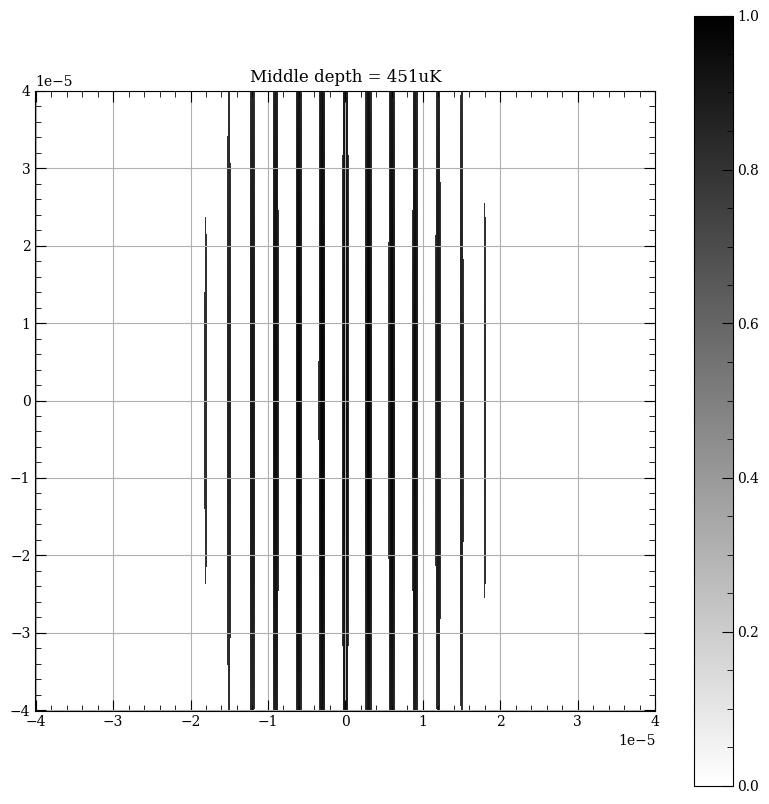

In [16]:
fig,ax = plt.subplots(figsize=[10,10])
p = ax.pcolormesh(X,Y,Zcut_red,vmin = 0, vmax = 1,cmap='gray_r')
title = "Middle depth = " + str(depth_red) + str("uK")
ax.set_aspect('equal')
ax.set_title(title)
plt.grid()
fig.colorbar(p,ax=ax)

# Back-reflected 3D lattice

Maximum trap depth in 3D: 3991  uK
Lattice spacing 0.3835 um
Trap frequency : 2pi x 657 kHz
Traps along x axis:  105
Traps along y axis:  1
squared array size  1  by 1


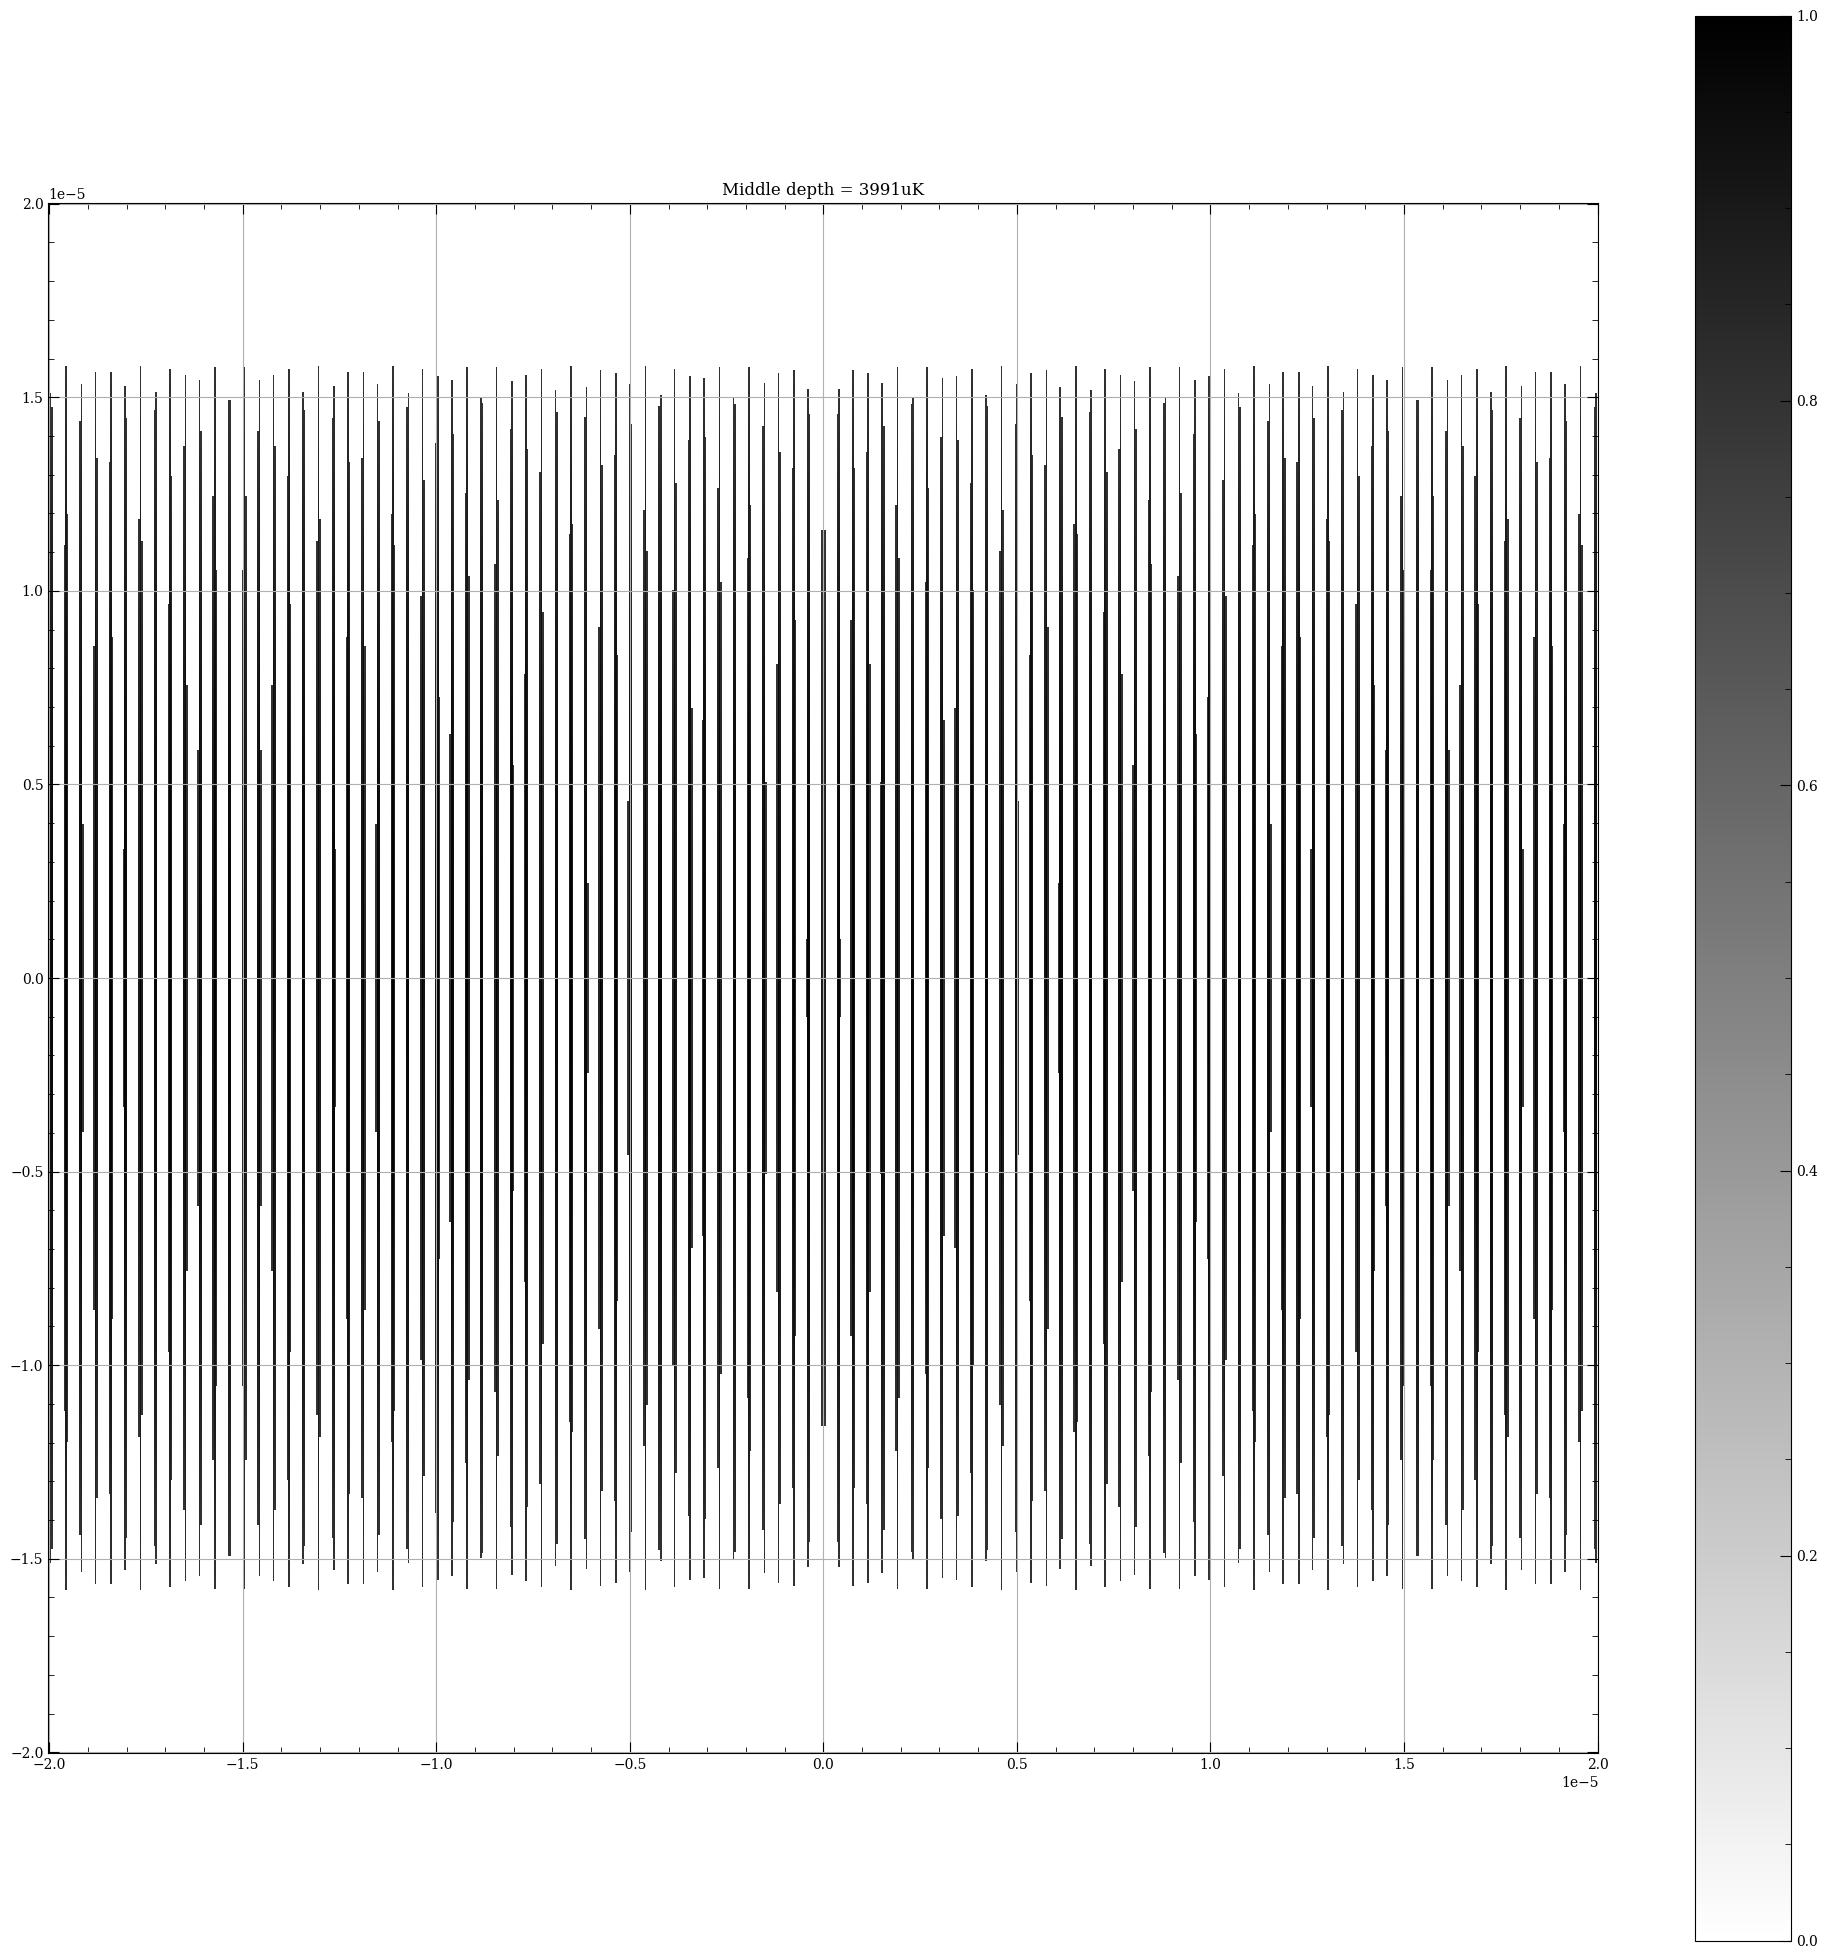

In [17]:
P_BR= 800e-3 # W. Power of a single beam. In total we have 6 for 3D confinement.
phi_BR = np.pi/2 # half the angle between the two crossing beams

#beam parameters: XY,Z
waist_BR =50e-6 # m

## Trap depth
U0_BR = 4*trap_depth_gaussian(polB_GS, P_BR, waist_BR, waist_BR) # Hz
U0_BR_inJ= U0_BR*const.h


depth_BR = round(3*U0_BR) # total trap depth
depth_BR_uK = round(depth_BR * const.h/const.k *1e6)
print("Maximum trap depth in 3D:",depth_BR_uK," uK")

#Lattice spacing
d_BR= laser_L/2 #lattice spacing in m
print("Lattice spacing", (d_BR*1e6), "um")

## Trap frequencies
k_L_BR= np.pi* np.sin(phi_BR)/laser_L 
mass_Rb = 87*const.u
omega_BR = (np.sqrt(8 * np.pi**2*(U0_BR_inJ/4)/(mass_Rb*d_BR**2))) / (2*np.pi) # 2pi because angular frequency, U/4 because U is the trap depth of a single gaussian beam
print("Trap frequency : 2pi x",round(omega_BR*1e-3), "kHz")


# Potential in space

grid= 20e-6
points_in_grid= 1001
x = np.linspace(-grid,grid,points_in_grid)
y = np.linspace(-grid,grid,points_in_grid)
X,Y = np.meshgrid(x,y)

Z = (potential(X,Y,0,phi_BR,waist_BR,waist_BR,laser_L, U0_BR/4,'x') + potential(X,Y,0,phi_BR,waist_BR,waist_BR,laser_L,U0_BR/4,'y') + potential(X,Y,0,phi_BR,waist_BR,waist_BR,laser_L,U0_BR/4,'z'))/depth_BR

# extract only the points where the trap depth is within 80% of the maxima
Zcut = Z.copy()
Zcut[(Z-0.8)<0] = 0
n_xaxis = len(argrelextrema(Zcut[round(points_in_grid/2)], np.greater)[0])
n_yaxis = len(argrelextrema(Zcut[:, round(points_in_grid/2)], np.greater)[0])
print("Traps along x axis: ", n_xaxis )
print("Traps along y axis: ", n_yaxis )

# assuming that is it roughly circular, calculate the lenght of the square inscribed the circle
square_lenght= round(min(n_xaxis, n_yaxis)/np.sqrt(2))
print("squared array size ",square_lenght, " by",square_lenght )
fig,ax = plt.subplots(figsize=[25,25])
p = ax.pcolormesh(X,Y,Zcut,vmin = 0, vmax = 1,cmap='gray_r')
title = "Middle depth = " + str(depth_BR_uK) + str("uK")
ax.set_aspect('equal')
ax.set_title(title)
plt.grid()
fig.colorbar(p,ax=ax)

# random calculations

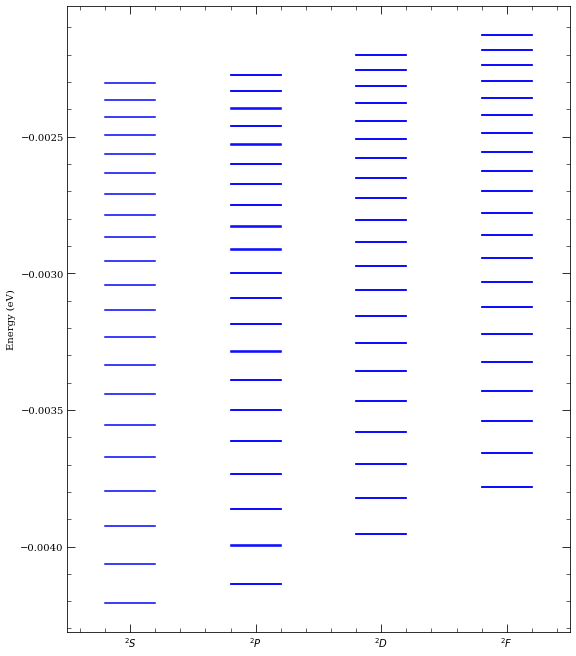

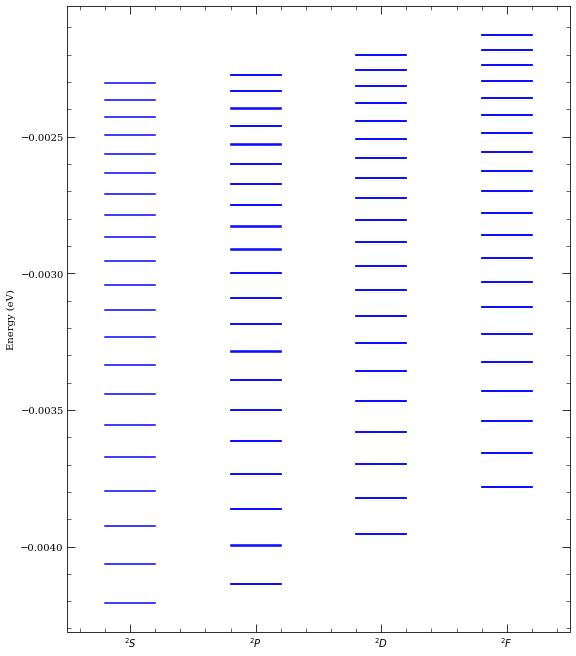

In [17]:
#Load parameters for Rb
atom=Rubidium87()

nmin=60  #Minimum n
nmax=80 #Maximum n
lmin=0  #Minimum l
lmax=3  #Maxmium l

#Plot Energy Levels of Cesium
levels = LevelPlot(atom)
levels.makeLevels(nmin,nmax,lmin,lmax)
levels.drawLevels()
levels.showPlot()

atom=Rubidium85()

nmin=60  #Minimum n
nmax=80 #Maximum n
lmin=0  #Minimum l
lmax=3  #Maxmium l

#Plot Energy Levels of Cesium
levels = LevelPlot(atom)
levels.makeLevels(nmin,nmax,lmin,lmax)
levels.drawLevels()
levels.showPlot()
